## Modelo de la red

In [1]:
import numpy as np

In [2]:
#Modelo 1 de red neuronal
#Implementar SGD para resolver la XOR.
#¿Cuántos parámetros desconocidos tiene el modelo?
# yhat, los pesos actualizados w +b, los parametros derivados dw, dx,dy,dz
#¿Cuáles son los hiper-parámetros del modelo? Explicar que pasa cuando se varía el learning rate.
#Learning rate,non_linearities
#Learning 
#Si el valor es muy pequeño la actualización se puede quedar atrapada en un minimo local y los valores de W y b no cambiarian correctamente, igualmente la red neuronal tardara mucho más tiempo en optimizar.

#Una vez entrenado el modelo, realizar predicciones para verificar el funcionamiento.

#Se implementaron dos modelos un MLP entregado por la especializacion (class MLP(object) ) y se trabajo en otro.# Modelo 2 de red neuronal

In [3]:
class MLP(object):
  def __init__(self, dims, optimizer_factory, non_linearities, input_dim, rng_seed = None):
    """
    Multilayer Perceptron class. 

    Params:
    ===============
    dims (list of int): list of number of neurons for each layer, including the output one.
    optimizer_factory (callable): function which returns an Optimizer object upon call.
    non_linearities (list of class): list of nonlinearities to be used after each layer, including the output one.
    input_dim (int): dimension of an individual input.
    rng_seed (int, optional): seed for initialization.

    Note: non_linearities and dims must be of same length.
    """
    # check lengths
    if len(dims) != len(non_linearities):
      raise ValueError("dims' and Non_linearities' lengths do not match")
    
    # initialize RNG
    rng = np.random.default_rng(rng_seed)

    # construct a list of Layers with matching dimension and non-linear activation function
    in_dims = [input_dim] + dims[:-1]
    self.layers = [Layer(n_in, n_out, non_linearity, optimizer_factory, rng) 
                    for n_in,n_out,non_linearity in zip(in_dims,dims, non_linearities)]


  def predict(self, X):
    """
    Produce a prediction for the n samples given in the form of a (input_dim, n) matrix.
    Params:
    ===============
    X (float, shape: input_dim x n): matrix of n samples, each of input_dim dimension.
    """
    # X can be interpreted as the output of a previous layer
    prediction = X

    # sequentially apply forward pass
    for layer in self.layers:
      prediction = layer.forward(prediction)

    return prediction
    
  def update(self, cost_gradient):
    """
    Propagate the errors through the layers.
    Params:
    ===============
    cost_gradient (float, shape: dims[-1] x 1)
    """
    
    # cost gradient is the cost derivative wrt last layer
    dY = cost_gradient

    # sequentially apply backwards update, in reversed order
    for layer in reversed(self.layers):
      dY = layer.backwards(dY)

In [4]:
class Layer(object):
  def __init__(self, n_in, n_out, non_linearity_class, optimizer_factory, rng):
    self.activation = non_linearity_class()
    self.optim = optimizer_factory()
    self.w = rng.standard_normal(size=(n_out, n_in))  * 0.1 # W shape is (n_out,n_in)
    self.b = rng.uniform(size=(n_out, 1))                   # b shape is (n_out, 1)

    #print(f"W= {self.w.shape}")
    #print(f"b= {self.b.shape}")
    # this may help later :)
    self.last_output = None
    self.last_input = None

  def forward(self, X):
    self.last_input = X
    
    z = self.w @ X + self.b

    self.last_output = self.activation.f(z)

    return self.last_output

  def backwards(self, dY):
    
    dz = dY * self.activation.df()

    dW = dz @ self.last_input.T

    db = np.sum(dz, axis=1, keepdims=True)

    dX = self.w.T @ dz

    self.w, self.b = self.optim.update(self.w, self.b, dW, db)

    return dX

In [5]:
class NonLinearity(object):

  def __init__(self):
    self.last_z = None
  
  def f(self, z):
    raise NotImplementedError("function evaluation not implemented")

  def df(self):
    raise NotImplementedError("function derivative not implemented")

In [6]:
class Relu(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return np.maximum(z,0)

  def df(self):
    return (self.last_z >= 0).astype(float)

In [7]:
class Sigmoid(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return np.around(1 / (1 + np.exp(-z)),5)
    
  def df(self):
    return np.round((self.last_z >= 0).astype(float),4)

In [8]:
class Identity(NonLinearity):

  def __init__(self):
    super().__init__()

  def f(self,z):
    self.last_z = z
    return z

  def df(self):
    return np.ones_like(self.last_z)  

In [9]:
class Optimizer(object):

  def update(self, W, b, dW, db):
    raise NotImplementedError("optimizer update rule not implemented")

In [10]:
class VGD(Optimizer):

  def __init__(self, learning_rate):
    self.lr = learning_rate

  def update(self, W_old, b_old, dW, db):
    # vanilla GD: theta_t+1 = theta_t - alpha * gradient
    W_new = W_old - self.lr * dW
    b_new = b_old - self.lr * db

    return W_new, b_new

def factory_VGD(lr):
  return lambda : VGD(lr)

In [11]:
class Cost(object):

  def score(self, Y_true, Y_hat):
    raise NotImplementedError("cost scoring function not implemented")

  def derivative(self, Y_true, Y_hat):
    raise NotImplementedError("cost derivative function not implemented")

In [12]:
class MSE(Cost):

  def score(self, Y_true, Y_hat):
    return 0.5 * np.average(np.square(Y_true - Y_hat))

  def derivative(self, Y_true, Y_hat):
    return (Y_hat - Y_true) / Y_hat.size

## Código para pruebas

In [13]:
# hiperparámetros

lr = 0.001
rng_seed = 6543
epochs = 1000

In [14]:
# initialization

# Model to learn the XOR truth table
X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]]) # XOR input
Y = np.array([[0, 1, 1, 0]]) # XOR output

# Define model parameters
neuronsInHiddenLayers = 8 # number of hidden layer neurons (2)
inputFeatures = X.shape[0] # number of input features (2)
outputFeatures = Y.shape[0] # number of output features (1)

epochs = 1000
lr = 0.001
losses = np.zeros((epochs, 1))


loss = MSE()
nn = MLP(
    dims = [neuronsInHiddenLayers,outputFeatures], 
    optimizer_factory = factory_VGD(lr), 
    non_linearities = [Relu, Identity], 
    input_dim = inputFeatures, 
    rng_seed = rng_seed
)


nn

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

train_costs_historic = np.empty(epochs, dtype=float)
test_costs_historic = np.empty(epochs, dtype=float)

for i in range(epochs):
  # learning on full-batches, but this could be a mini-batch sampling procedure
  x = X
  y = Y

  ## note: as net saves last run, it's important that the run before the update is the train one
  ## so... we predict on test first, then train :)
  test_cost = loss.score(y,nn.predict(x))

  # forward pass
  y_hat = nn.predict(x)

  # calculate costs
  train_cost = loss.score(y, y_hat)
  

  # save them, inform the train cost every 20 epochs
  train_costs_historic[i] = train_cost
  test_costs_historic[i] = test_cost

  if((i+1) % 20 == 0):
    print(f"Train cost on epoch {i+1} is {train_cost:5.3f}")
  
  # backwards pass
  gradient = loss.derivative(y, y_hat)
  nn.update(gradient)

Train cost on epoch 20 is 0.166
Train cost on epoch 40 is 0.162
Train cost on epoch 60 is 0.158
Train cost on epoch 80 is 0.155
Train cost on epoch 100 is 0.151
Train cost on epoch 120 is 0.149
Train cost on epoch 140 is 0.146
Train cost on epoch 160 is 0.144
Train cost on epoch 180 is 0.142
Train cost on epoch 200 is 0.140
Train cost on epoch 220 is 0.139
Train cost on epoch 240 is 0.137
Train cost on epoch 260 is 0.136
Train cost on epoch 280 is 0.135
Train cost on epoch 300 is 0.134
Train cost on epoch 320 is 0.133
Train cost on epoch 340 is 0.132
Train cost on epoch 360 is 0.131
Train cost on epoch 380 is 0.131
Train cost on epoch 400 is 0.130
Train cost on epoch 420 is 0.130
Train cost on epoch 440 is 0.129
Train cost on epoch 460 is 0.129
Train cost on epoch 480 is 0.128
Train cost on epoch 500 is 0.128
Train cost on epoch 520 is 0.128
Train cost on epoch 540 is 0.127
Train cost on epoch 560 is 0.127
Train cost on epoch 580 is 0.127
Train cost on epoch 600 is 0.127
Train cost on 

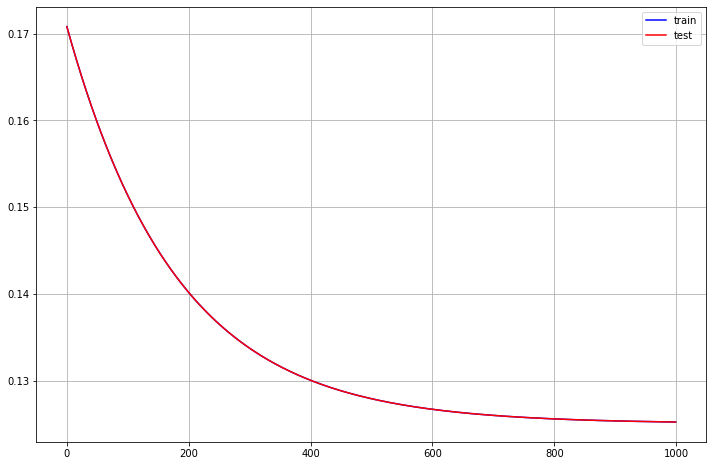

In [16]:
plt.figure(figsize=(12,8))
plt.plot(train_costs_historic, color='blue', label='train')
plt.plot(test_costs_historic, color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()


In [17]:
# test predict shape
x = np.array([[1, 1, 0, 0], [0, 1, 0, 1]]) # XOR input
prediction = nn.predict(x)
print(f"Shape of prediction is {prediction.shape}")
print(f"Shape of prediction is {prediction}")

# test MSE cost
print(f"Avg cost on untrained prediction is {loss.score(y,prediction)}")

gradient = loss.derivative(y,prediction)
print(f"Gradient shape is {gradient.shape} with average {np.average(gradient)}")

Shape of prediction is (1, 4)
Shape of prediction is [[0.5083332  0.52807609 0.51009834 0.52984123]]
Avg cost on untrained prediction is 0.12523127309578547
Gradient shape is (1, 4) with average 0.004771804293470003


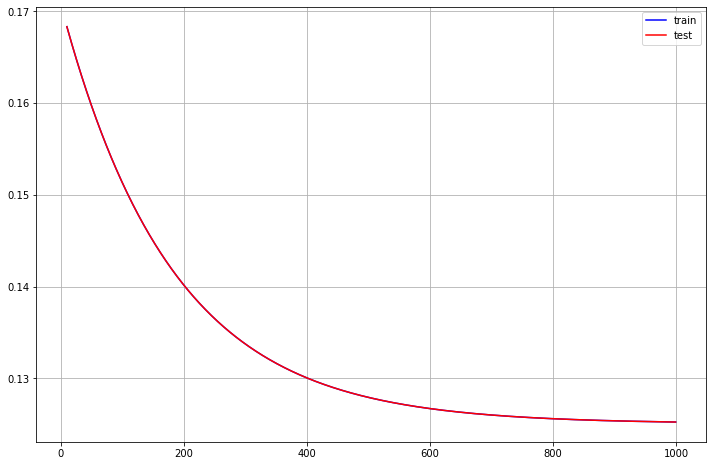

In [18]:
# first values are off scale, omit first 10
omit_idx = 10
idxs = range(omit_idx, len(train_costs_historic))
plt.figure(figsize=(12,8))
plt.plot(idxs, train_costs_historic[omit_idx:], color='blue', label='train')
plt.plot(idxs, test_costs_historic[omit_idx:], color='red', label='test')
plt.grid(True)
plt.legend()
plt.show()

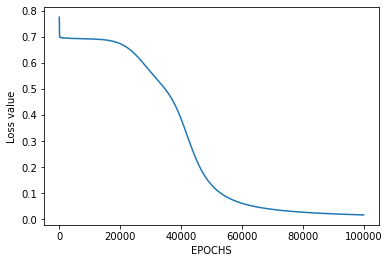

[[0.98229285 0.01889404 0.01488829 0.9822564 ]]
[[1. 0. 0. 1.]]


In [19]:
# Modelo 2 de red neuronal
# import Python Libraries m
import numpy as np
from matplotlib import pyplot as plt

# Sigmoid Function
def sigmoid(z):
	return 1 / (1 + np.exp(-z))

# Initialization of the neural network parameters
# Initialized all the weights in the range of between 0 and 1
# Bias values are initialized to 0
def initializeParameters(inputFeatures, neuronsInHiddenLayers, outputFeatures):
	W1 = np.random.randn(neuronsInHiddenLayers, inputFeatures)
	W2 = np.random.randn(outputFeatures, neuronsInHiddenLayers)
	b1 = np.zeros((neuronsInHiddenLayers, 1))
	b2 = np.zeros((outputFeatures, 1))
	
	parameters = {"W1" : W1, "b1": b1,
				"W2" : W2, "b2": b2}
	return parameters

# Forward Propagation
def forwardPropagation(X, Y, parameters):
	m = X.shape[1]
	W1 = parameters["W1"]
	W2 = parameters["W2"]
	b1 = parameters["b1"]
	b2 = parameters["b2"]

	Z1 = np.dot(W1, X) + b1
	A1 = sigmoid(Z1)
	Z2 = np.dot(W2, A1) + b2
	A2 = sigmoid(Z2)

	cache = (Z1, A1, W1, b1, Z2, A2, W2, b2)
	logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
	cost = -np.sum(logprobs) / m
	return cost, cache, A2

# Backward Propagation
def backwardPropagation(X, Y, cache):
	m = X.shape[1]
	(Z1, A1, W1, b1, Z2, A2, W2, b2) = cache
	
	dZ2 = A2 - Y
	dW2 = np.dot(dZ2, A1.T) / m
	db2 = np.sum(dZ2, axis = 1, keepdims = True)
	
	dA1 = np.dot(W2.T, dZ2)
	dZ1 = np.multiply(dA1, A1 * (1- A1))
	dW1 = np.dot(dZ1, X.T) / m
	db1 = np.sum(dZ1, axis = 1, keepdims = True) / m
	
	gradients = {"dZ2": dZ2, "dW2": dW2, "db2": db2,
				"dZ1": dZ1, "dW1": dW1, "db1": db1}
	return gradients

# Updating the weights based on the negative gradients
def updateParameters(parameters, gradients, learningRate):
	parameters["W1"] = parameters["W1"] - learningRate * gradients["dW1"]
	parameters["W2"] = parameters["W2"] - learningRate * gradients["dW2"]
	parameters["b1"] = parameters["b1"] - learningRate * gradients["db1"]
	parameters["b2"] = parameters["b2"] - learningRate * gradients["db2"]
	return parameters

# Model to learn the XOR truth table
X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]]) # XOR input
Y = np.array([[0, 1, 1, 0]]) # XOR output

# Define model parameters
neuronsInHiddenLayers = 2 # number of hidden layer neurons (2)
inputFeatures = X.shape[0] # number of input features (2)
outputFeatures = Y.shape[0] # number of output features (1)
parameters = initializeParameters(inputFeatures, neuronsInHiddenLayers, outputFeatures)
epoch = 100000
learningRate = 0.01
losses = np.zeros((epoch, 1))

for i in range(epoch):
	losses[i, 0], cache, A2 = forwardPropagation(X, Y, parameters)
	gradients = backwardPropagation(X, Y, cache)
	parameters = updateParameters(parameters, gradients, learningRate)

# Evaluating the performance
plt.figure()
plt.plot(losses)
plt.xlabel("EPOCHS")
plt.ylabel("Loss value")
plt.show()

# Testing
X = np.array([[1, 1, 0, 0], [0, 1, 0, 1]]) # XOR input
cost, _, A2 = forwardPropagation(X, Y, parameters)
prediction = (A2 > 0.5) * 1.0
print(A2)
print(prediction)
